Mukta Mohindra Final project- 
Sentiment Analysis Twitter text

In [ ]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re


required = {'spacy', 'scikit-learn', 'numpy', 
            'pandas', 'torch', 'matplotlib', 'wordcloud'}
 #           'transformers', 'allennlp==0.9.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
#import transformers

from spacy.lang.en import English
!python -m spacy download en_core_web_md
import en_core_web_md
en = English()
nlp = en_core_web_md.load()





✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Read Data

In [ ]:
import pandas as pd
data_location='tweet.1600000.csv'
DATASET_COLUMNS = ["Target", "ids", "postdate", "qryflag", "username", "text"]
DATASET_ENCODING =  "ISO-8859-1"
df = pd.read_csv(data_location, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df.head()
df['Target'].value_counts()
# 0 is negative sentiment and 4 is positive

4    800000
0    800000
Name: Target, dtype: int64

In [ ]:
#Ensure GPU active
torch.cuda.is_available()

True

In [ ]:
print(len(df))
df.info()
df.describe()
#save dataframe 
with open('all_tweets.pkl', 'wb') as f:
    pickle.dump(df,f)

1600000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Target    1600000 non-null  int64 
 1   ids       1600000 non-null  int64 
 2   postdate  1600000 non-null  object
 3   qryflag   1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
#read in dataframe
with open('all_tweets.pkl', 'rb') as f:
    df = pickle.load(f)
print(df.head())
print(df.columns, len(df))




   Target  ...                                               text
0       0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  ...  is upset that he can't update his Facebook by ...
2       0  ...  @Kenichan I dived many times for the ball. Man...
3       0  ...    my whole body feels itchy and like its on fire 
4       0  ...  @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]
Index(['Target', 'ids', 'postdate', 'qryflag', 'username', 'text'], dtype='object') 1600000


In [ ]:
# shuffle
from sklearn.utils import shuffle
#create pickle files for different datasets , dont know when i will run out of memory
df_tweet = shuffle(df)
df_tweet = df_tweet[:5000]

df_tweet = df_tweet.drop(['ids','postdate','qryflag','username'], axis=1).reset_index(drop=True)
print(df_tweet.head())
print(len(df_tweet),'\n', df_tweet["Target"].value_counts())
with open('clean_tweets_5k.pkl', 'wb') as f:
    pickle.dump(df_tweet,f)

   Target                                               text
0       4  Watching this movie again  I'm gonna watch it ...
1       4  Playin' poker with friends, they don't look to...
2       4                          lovin' the new piercing. 
3       0  Good morning kiddies! Shall we see what the da...
4       0    wishing warped tour came to london canada..... 
5000 
 0    2556
4    2444
Name: Target, dtype: int64


Data Exploration

In [ ]:
with open('clean_tweets_10k.pkl', 'rb') as f:
    df_tweet = pickle.load(f)
print(df_tweet.head())
df_tweet.info()
print(len(df_tweet))
##clean out any rows with null values

df_tweet.describe()

   Target                                               text
0       4  @gypsy_sunday :O omg oh yes, I always forget a...
1       4  at least i know @sarahtondryk and family will ...
2       0      Yesterday it was sunny and today its raining 
3       4  Going to see Chelsea Art College today.. shoul...
4       0  woken up 'early' 3days in a row and im exhaust...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
10000


,Target
count,10000.000000
mean,1.994400
std,2.000092
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,4.000000


#Check the count of positive and negative tweets, 4 being positive

In [ ]:
df_tweet["Target"].value_counts()

0    5014
4    4986
Name: Target, dtype: int64

Index(['Target', 'text'], dtype='object') RangeIndex(start=0, stop=2, step=1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Count')

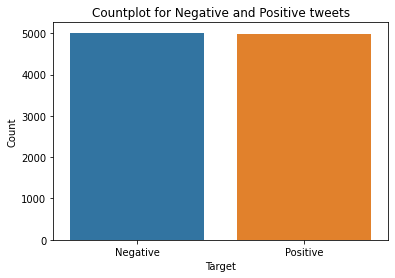

In [ ]:
# see how many tweets are positive vs negative
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df_count = df_tweet.groupby('Target').count().reset_index()
print(df_count.columns, df_count.index)
df_count['Target']= df_count['Target'].replace([0,4],['Negative','Positive'])
#print(df_count, df_count.columns, df_count.index)
df_count
ax = sns.barplot(data=df_count,x='Target', y='text')
ax.set_title('Countplot for Negative and Positive tweets')
ax.set_ylabel('Count')

Mukta- Almost same number of positive and negative reviews show in value counts

In [ ]:
df_tweet.iloc[5]['text']

'@Galiiit lmao thats a good one. we havent thought of that one we have hobo weekly. hobos day. the daily hobo hobo life and total hobo '

In [ ]:
#remove punctuation and URLs, and stopwords
def tokenize(text, model=nlp, nostopwds=True,  lemma=False):
   
    tokenlist = []
    doc = model(text)
    ent = ''
    for t in doc:
      
      if nostopwds and t.is_stop:
        #print(t.text)
        continue
      if t.like_url:
        tokenlist.append('URL')
        continue
      if not t.is_alpha:
        continue      
      if lemma:
        #print('lemma',text)
        tokenlist.append(t.lemma_)
      else:
        tokenlist.append(t.lower_)
    return tokenlist

text= "Lol, th? oh you got &amp friend for the d?g ?.. U.S. I'm at a  buffet... Cine there got amore wat... "
tokenize(text,nostopwds=False)

#print(df_tweet.iloc[1000]['text'])
#tokenize(df_tweet.iloc[1000]['text'], nostopwds=False)



['lol',
 'th',
 'oh',
 'you',
 'got',
 'amp',
 'friend',
 'for',
 'the',
 'i',
 'at',
 'a',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

#Create wordcloud for positive and negative tweets to see which words have high frequency

In [ ]:
pos_tokenlist=[" ".join(tokenize(str(d))) for d in df_tweet[df_tweet['Target']==4]['text']]


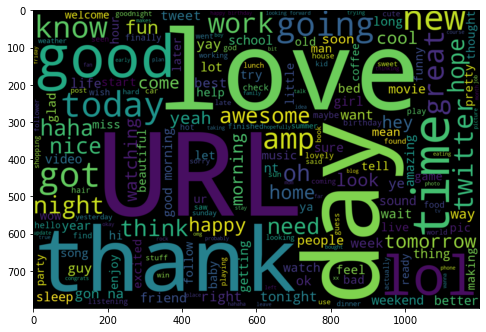

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (8,8)) # Text Reviews with positive Ratings
wordcloud = WordCloud(min_font_size = 3,  max_words = 200 , width = 1200 , height = 800).generate(" ".join(pos_tokenlist))
plt.imshow(wordcloud,interpolation = 'bilinear')

  


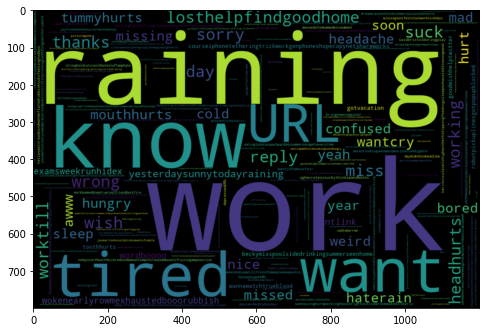

In [ ]:
neg_tokenlist=["".join(tokenize(str(d))) for d in df_tweet[df_tweet['Target']==0]['text']]
from wordcloud import WordCloud
plt.figure(figsize = (8,8)) # Text Reviews with positive Ratings
wordcloud = WordCloud(min_font_size = 3,  max_words = 200 , width = 1200 , height = 800).generate(" ".join(neg_tokenlist))
plt.imshow(wordcloud,interpolation = 'bilinear')


Most common words are bolder

#Creating tokenlist with stop words, want to see if number of words in a tweet can help differentiate positive from negative

In [ ]:


tokenlist = [tokenize(str(d), nostopwds=False) for d in  df_tweet['text'] ]

print(tokenlist[5])
with open('tokenlist_stop.pkl', 'wb') as f:
    pickle.dump(tokenlist,f)


['i', 'had', 'a', 'ton', 'of', 'fun', 'at', 'clan', 'wars', 'with', 'everyone']


In [ ]:
with open('tokenlist_stop.pkl', 'rb') as f:
    tokenlist = pickle.load(f)
print(len(tokenlist))
#Find number of words in each tweet
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vec_cv = cv.fit_transform(tokenlist).toarray()
print('cv vector',vec_cv.shape)
print('vocabulary', len(cv.vocabulary_))

10000
cv vector (10000, 12848)
vocabulary 12848


In [ ]:

df_cv = pd.DataFrame(vec_cv, columns=cv.get_feature_names())

df_cv["num_words"]=df_cv.sum(axis=1)

print(df_cv.head())
#pos_cv= df_cv[df_tweet[df_tweet["Target"]==4].index]

df_label = df_tweet["Target"]

print(len(df_label), len(df_cv))
comb_cv = pd.concat( [df_label, df_cv], axis=1)



   URL  a  aa  aaaaaa  aaaaahhhh  aaaaalll  ...  ã  è  ð  ðº  ñ  num_words
0    0  0   0       0          0         0  ...  0  0  0   0  0         24
1    0  0   0       0          0         0  ...  0  0  0   0  0         15
2    0  0   0       0          0         0  ...  0  0  0   0  0          8
3    0  0   0       0          0         0  ...  0  0  0   0  0         14
4    0  1   0       0          0         0  ...  0  0  0   0  0         14

[5 rows x 12849 columns]
10000 10000


In [ ]:
print(type(comb_cv))

<class 'pandas.core.frame.DataFrame'>


In [ ]:

pos_cv= df_cv[comb_cv["Target"]==4]
neg_cv= df_cv[comb_cv["Target"]==0]
print(len(pos_cv), len(neg_cv))

4986 5014


Text(0.5, 0, 'Number of words')

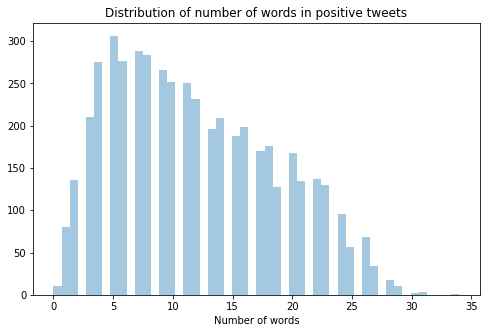

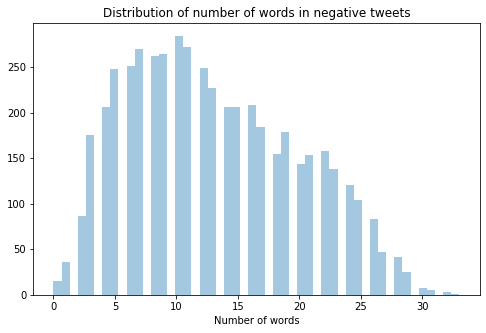

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#fig,ax = plt.subplots(1,2, figsize=(15,10))
plt.figure(figsize=(8,5)) 
ax1=sns.distplot(pos_cv['num_words'], kde=False,  bins=50)
ax1.set_title('Distribution of number of words in positive tweets')
ax1.set_xlabel('Number of words')
plt.figure(figsize=(8,5)) 
ax2=sns.distplot(neg_cv['num_words'], kde=False, bins=50)
ax2.set_title('Distribution of number of words in negative tweets')
ax2.set_xlabel('Number of words')


Mukta - There is no relationship between length of a tweet and positve vs negative tweets.

#Let us explore  top 20 key words in negative and positive tweets, see if that is an indicator of the sentiment. Want to get rid of the stopwords for this.

In [ ]:

tokenlist_nostop = [tokenize(str(d)) for d in  df_tweet['text'] ]
with open('tokenlist_nostop.pkl', 'wb') as f:
    pickle.dump(tokenlist_nostop,f)


In [ ]:
with open('tokenlist_nostop.pkl', 'rb') as f:
    tokenlist_nostop= pickle.load(f)
pos_tweet = df_tweet[df_tweet["Target"]==4]
neg_tweet = df_tweet[df_tweet["Target"]==0]
tf = TfidfVectorizer(tokenizer=tokenize,  min_df=.01,ngram_range=(1,3))


In [ ]:
vec_tf = tf.fit(df_tweet['text'])


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
pos_tf= vec_tf.transform(pos_tweet['text']).toarray()
neg_tf = vec_tf.transform(neg_tweet['text']).toarray()
print(pos_tf.shape, neg_tf.shape)

(4986, 70) (5014, 70)


In [ ]:
pos_tf = pd.DataFrame(pos_tf, columns=tf.get_feature_names())
neg_tf = pd.DataFrame(neg_tf, columns=tf.get_feature_names())
pos_words=pos_tf.sum().nlargest(10)
print(pos_words)
neg_words=(neg_tf.sum().nlargest(10))
print(neg_words)

URL       264.785887
good      228.338478
love      201.045584
day       168.076775
thanks    160.267493
like      159.660788
lol       141.276453
new       126.513827
got       123.214957
going     118.077422
dtype: float64
work     179.265983
nt       172.058023
today    155.992551
like     155.652311
day      147.256893
got      145.275765
want     141.365342
miss     123.596733
URL      123.406330
going    121.091674
dtype: float64


#Positive words seem meaningful but not the negative words but lets do log likelihood to see which words can be a good candidate for modeling

In [ ]:
from numpy import log, mean
def log_likelihood(analysis, reference, word):
    # count of word in source
    a = analysis[word].sum()
    # count of word in reference
    b = reference[word].sum()
    # count of all words in source
    c = analysis.sum().sum()
    # count of all words in reference
    d = reference.sum().sum()
    print('counts analysis:', a)
    print('counts reference:', b)
    e1 = c*(a+b)/(c+d)
    e2 = d*(a+b)/(c+d)
    g = 2*((a*log(a/e1)) + (b*log(b/e2)))
    print('G2: ', g)

# function to do likelihood ratio test
top_words = (pos_words+neg_words).index.tolist()
print(type(top_words))
for w in top_words:
    print(w)
    log_likelihood(neg_tf, pos_tf, w)
   

<class 'list'>
URL
counts analysis: 123.40632987628292
counts reference: 264.7858871164424
G2:  51.76426756747939
day
counts analysis: 147.25689278625296
counts reference: 168.07677474614212
G2:  1.2415637678829228
going
counts analysis: 121.09167447226632
counts reference: 118.07742175247775
G2:  0.06050573475406518
good
counts analysis: 103.505935121589
counts reference: 228.3384777877164
G2:  47.313838092811295
got
counts analysis: 145.27576469127894
counts reference: 123.21495691307396
G2:  1.9633237332652271
like
counts analysis: 155.65231079164835
counts reference: 159.66078785232486
G2:  0.02792409810532126
lol
counts analysis: 96.5591189614534
counts reference: 141.2764527428763
G2:  8.16516158268707
love
counts analysis: 66.26083477230148
counts reference: 201.04558367251244
G2:  70.29603375629647
miss
counts analysis: 123.59673284482903
counts reference: 27.64863550397206
G2:  66.43453747300286
new
counts analysis: 73.63938971956549
counts reference: 126.5138265211244
G2:  13

#Let us do modeling based on words with log likelihood > 10. Refer BasicModel.ipynb